In [3]:
import sys 
sys.path.insert(1, "../")
from workloads.util import use_plots

import seaborn as sns 
from matplotlib import pyplot as plt
sns.set()

import pandas as pd
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import os

import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plots_dir = use_plots("ml-1m", download=False)
predictions = pd.read_csv(f"{plots_dir}/predictions.csv")

{'results_dir': '/Users/sarahwooders/repos/experiments/data/results', 'dataset_dir': '/Users/sarahwooders/repos/experiments/data/datasets', 'plots_dir': '/Users/sarahwooders/repos/experiments/data/plots', 'aws_dir': 'vldb', 'credentials': '/Users/sarahwooders/repos/experiments/ralf-vldb.json'}


In [5]:
predictions['pred_diff'] = predictions['y_pred'] - predictions['y_true']
predictions['diff_sq'] = predictions['pred_diff'] ** 2
predictions = predictions[predictions['policy'].isin(['total_error_cold', 'min_past'])]

In [6]:
predictions

,Unnamed: 0.1,Unnamed: 0,y_true,y_pred,user_id,movie_id,timestamp,policy,updates,ts_factor,pred_diff,diff_sq
900000,0,0,3,3.715949,895,223,0,total_error_cold,0.5,60,0.715949,0.512583
900001,1,1,5,4.496678,895,2336,0,total_error_cold,0.5,60,-0.503322,0.253333
900002,2,2,4,3.805784,895,2369,0,total_error_cold,0.5,60,-0.194216,0.037720
900003,3,3,2,3.715616,895,1911,0,total_error_cold,0.5,60,1.715616,2.943338
900004,4,4,3,4.349813,895,2599,0,total_error_cold,0.5,60,1.349813,1.821995
...,...,...,...,...,...,...,...,...,...,...,...,...
4499995,99995,99995,4,3.526553,319,2671,20018,min_past,8.0,60,-0.473447,0.224152
4499996,99996,99996,3,3.518007,319,2759,20018,min_past,8.0,60,0.518007,0.268331
4499997,99997,99997,2,4.104482,326,1263,20018,min_past,8.0,60,2.104482,4.428844
4499998,99998,99998,3,4.517343,326,1193,20018,min_past,8.0,60,1.517343,2.302330


In [7]:
# Remove Outliers
from scipy import stats
predictions = predictions[(np.abs(stats.zscore(predictions['diff_sq'])) < 3)]

In [8]:
predictions

,Unnamed: 0.1,Unnamed: 0,y_true,y_pred,user_id,movie_id,timestamp,policy,updates,ts_factor,pred_diff,diff_sq
900000,0,0,3,3.715949,895,223,0,total_error_cold,0.5,60,0.715949,0.512583
900001,1,1,5,4.496678,895,2336,0,total_error_cold,0.5,60,-0.503322,0.253333
900002,2,2,4,3.805784,895,2369,0,total_error_cold,0.5,60,-0.194216,0.037720
900003,3,3,2,3.715616,895,1911,0,total_error_cold,0.5,60,1.715616,2.943338
900004,4,4,3,4.349813,895,2599,0,total_error_cold,0.5,60,1.349813,1.821995
...,...,...,...,...,...,...,...,...,...,...,...,...
4499995,99995,99995,4,3.526553,319,2671,20018,min_past,8.0,60,-0.473447,0.224152
4499996,99996,99996,3,3.518007,319,2759,20018,min_past,8.0,60,0.518007,0.268331
4499997,99997,99997,2,4.104482,326,1263,20018,min_past,8.0,60,2.104482,4.428844
4499998,99998,99998,3,4.517343,326,1193,20018,min_past,8.0,60,1.517343,2.302330


In [9]:
min_past_error = predictions[predictions['policy'] == 'min_past'].groupby('updates').mean()['diff_sq']

In [10]:
error_cold_error = predictions[predictions['policy'] == 'total_error_cold'].groupby('updates').mean()['diff_sq']

In [11]:
overall_dataset_per_diff = min_past_error - error_cold_error

Now we look at the dataset we've trained on, and whether that influences the percent error difference across policies.

In [12]:
past_updates =  pd.read_pickle(f'{plots_dir}/past_updates.pkl')

In [13]:
trained_predictions = predictions[predictions['user_id'].isin(past_updates)]
untrained_predictions = predictions[~predictions['user_id'].isin(past_updates)]

In [14]:
min_past_train_error = trained_predictions[trained_predictions['policy'] == 'min_past'].groupby('updates').mean()['diff_sq']
cold_train_error = trained_predictions[trained_predictions['policy'] == 'total_error_cold'].groupby('updates').mean()['diff_sq']

In [15]:
trained_dataset_per_diff = min_past_train_error - cold_train_error

In [16]:
min_past_untrain_error = untrained_predictions[untrained_predictions['policy'] == 'min_past'].groupby('updates').mean()['diff_sq']
cold_untrain_error = untrained_predictions[untrained_predictions['policy'] == 'total_error_cold'].groupby('updates').mean()['diff_sq']

In [17]:
untrained_dataset_per_diff = min_past_untrain_error - cold_untrain_error

Now we look for whether bursty periods of time influence the percent error difference. I've defined bursty to be more than 200 ratings/timestamp, but you can change it to be whatever threshold you think is appropriate.

In [18]:
threshold = 200

In [19]:
temp_table = predictions[predictions['policy'] == 'min_past'].groupby('timestamp').count().sort_values('user_id', ascending = False)

In [20]:
timestamp_num = {}
for index, row in temp_table.iterrows():
    timestamp_num[index] = row['user_id']

In [21]:
new_table = predictions.copy(deep=True)

In [22]:
new_table['num_per_timestamp'] = new_table.apply(lambda x: timestamp_num[x['timestamp']], axis=1)

In [23]:
above_threshold = new_table[new_table['num_per_timestamp'] > threshold]

In [24]:
min_past_above_error = above_threshold[above_threshold['policy'] == 'min_past'].groupby('updates').mean()['diff_sq']
cold_above_error = above_threshold[above_threshold['policy'] == 'total_error_cold'].groupby('updates').mean()['diff_sq']

In [25]:
bursty_dataset_per_diff = min_past_above_error - cold_above_error

In [26]:
d = {"updates": sorted(list(set(predictions['updates']))), 'overall': overall_dataset_per_diff, 'trained': trained_dataset_per_diff, 'untrained': untrained_dataset_per_diff, 'bursty': bursty_dataset_per_diff}
conclusion_df = pd.DataFrame(data=d).drop('updates', axis=1)

In [27]:
conclusion_df

,overall,trained,untrained,bursty
updates,,,,
0.20,9.638115e-03,2.088318e-01,7.353174e-03,4.201531e-03
0.25,1.007647e-02,2.378742e-01,7.476865e-03,5.819464e-03
0.50,5.643904e-03,-1.328223e-02,5.857535e-03,9.365993e-03
1.00,4.871532e-03,5.240128e-02,4.323165e-03,1.226468e-02
2.00,1.984951e-03,5.699049e-04,2.000418e-03,4.876170e-03
3.00,3.528289e-04,4.838348e-04,3.513234e-04,1.088770e-03
4.00,-2.153553e-04,-1.969289e-03,-1.940934e-04,-6.507257e-04
5.00,-2.023452e-04,9.489643e-04,-2.156128e-04,-7.240916e-04
8.00,4.555895e-08,-1.946566e-08,4.630686e-08,3.098897e-07


In [28]:
conclusion_df.T

updates,0.20,0.25,0.50,1.00,2.00,3.00,4.00,5.00,8.00
overall,0.009638,0.010076,0.005644,0.004872,0.001985,0.000353,-0.000215,-0.000202,4.555895e-08
trained,0.208832,0.237874,-0.013282,0.052401,0.000570,0.000484,-0.001969,0.000949,-1.946566e-08
untrained,0.007353,0.007477,0.005858,0.004323,0.002000,0.000351,-0.000194,-0.000216,4.630686e-08
bursty,0.004202,0.005819,0.009366,0.012265,0.004876,0.001089,-0.000651,-0.000724,3.098897e-07


In [29]:
policy_map = {
    'total_error': 'Regret-Proportional',
    'total_error_cold': 'Regret-Proportional',
    'min_past': 'Minimum-Past', 
    'round_robin': "Round-Robin", 
    'max_pending': "Maximum-Pending", 
    'last_query': "Read-Optimized", 
    "query_proportional": "Query-Proportional",
    "batch": "Batched", 
    'random': "Random"
}
hue_order = ['Trained', 'Untrained']
def hex_to_rgb(hex):
  rgb = []
  for i in (0, 2, 4):
    decimal = int(hex[i:i+2], 16)
    rgb.append(decimal/256)
  
  return tuple(rgb)


colors = sns.color_palette(as_cmap=True)
#colors_hex = ["d0e2ff", "4589ff", "a8a8a8", "8d8d8d", "6f6f6f", "525252", "393939"]
colors_hex = ["656565", "a9a9a9", "002d9c", "0f62fe", "78a9ff", "a6c8ff", "d0e2ff", "8d8d8d"]
colors = [hex_to_rgb(c) for c in colors_hex]
hue_colors = {hue_order[i]: colors[i] for i in range(len(hue_order))}
hue_colors

{'Trained': (0.39453125, 0.39453125, 0.39453125),
 'Untrained': (0.66015625, 0.66015625, 0.66015625)}

In [30]:
sns.set_theme(style="whitegrid")
sns.set_theme(style="whitegrid", font_scale=1.7)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [31]:
conclusion_df

,overall,trained,untrained,bursty
updates,,,,
0.20,9.638115e-03,2.088318e-01,7.353174e-03,4.201531e-03
0.25,1.007647e-02,2.378742e-01,7.476865e-03,5.819464e-03
0.50,5.643904e-03,-1.328223e-02,5.857535e-03,9.365993e-03
1.00,4.871532e-03,5.240128e-02,4.323165e-03,1.226468e-02
2.00,1.984951e-03,5.699049e-04,2.000418e-03,4.876170e-03
3.00,3.528289e-04,4.838348e-04,3.513234e-04,1.088770e-03
4.00,-2.153553e-04,-1.969289e-03,-1.940934e-04,-6.507257e-04
5.00,-2.023452e-04,9.489643e-04,-2.156128e-04,-7.240916e-04
8.00,4.555895e-08,-1.946566e-08,4.630686e-08,3.098897e-07


In [32]:
sorted(list(set(predictions['updates']))) + sorted(list(set(predictions['updates'])))

[0.2,
 0.25,
 0.5,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 8.0,
 0.2,
 0.25,
 0.5,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 8.0]

In [33]:
new_d = {'updates': sorted(list(set(predictions['updates']))) + sorted(list(set(predictions['updates']))), 'mse': list(trained_dataset_per_diff) + list(untrained_dataset_per_diff), 'trained': ["Trained"] * len(trained_dataset_per_diff) + ["Untrained"] * len(trained_dataset_per_diff)}
new_df = pd.DataFrame(data=new_d)

In [34]:
new_df

,updates,mse,trained
0,0.20,2.088318e-01,Trained
1,0.25,2.378742e-01,Trained
2,0.50,-1.328223e-02,Trained
3,1.00,5.240128e-02,Trained
4,2.00,5.699049e-04,Trained
5,3.00,4.838348e-04,Trained
6,4.00,-1.969289e-03,Trained
7,5.00,9.489643e-04,Trained
8,8.00,-1.946566e-08,Trained
9,0.20,7.353174e-03,Untrained


In [42]:
updates = [0.25, 1, 4]
trimmed_df = new_df[new_df.updates.isin(updates)]
trimmed_df

,updates,mse,trained
1,0.25,0.237874,Trained
3,1.00,0.052401,Trained
6,4.00,-0.001969,Trained
10,0.25,0.007477,Untrained
12,1.00,0.004323,Untrained
15,4.00,-0.000194,Untrained


<AxesSubplot:xlabel='updates', ylabel='mse'>

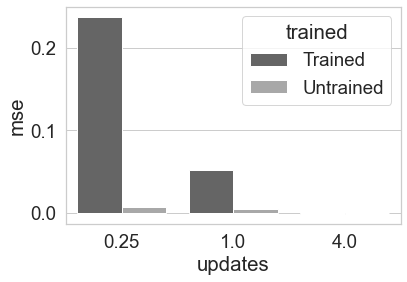

In [43]:
sns.barplot(data=trimmed_df, x="updates", y="mse", hue="trained", palette=hue_colors)

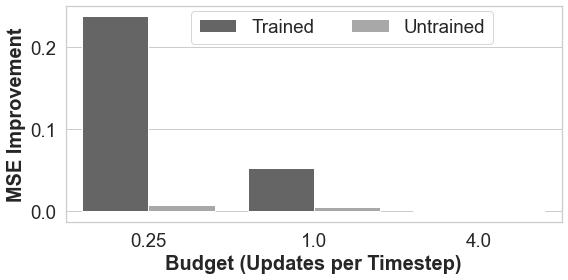

In [65]:
fig, axes = plt.subplots(1, 1, figsize=(8,4))

g0 = sns.barplot(data=trimmed_df, x="updates", y="mse", hue="trained", palette=hue_colors)
#axes.set(title="Recommendation", xlabel="Budget (Updates per Timestep)",  ylabel="MSE")
axes.set_xlabel("Budget (Updates per Timestep)", fontsize=20, fontweight="bold")
axes.set_ylabel("MSE Improvement", fontsize=20, fontweight="bold")
#axes.set_title("Regret-Proportinal vs. Minimum-Past", fontsize=24)
g0.legend_.remove()
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.6, 0.8))
fig.tight_layout()

fig.savefig('../data/plots/user.pdf', dpi=300, bbox_inches = "tight")

In [110]:
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, 1))
fig.tight_layout()

In [112]:
axes.set(ylim=(-.0000001, .0000001))

[(-1e-07, 1e-07)]

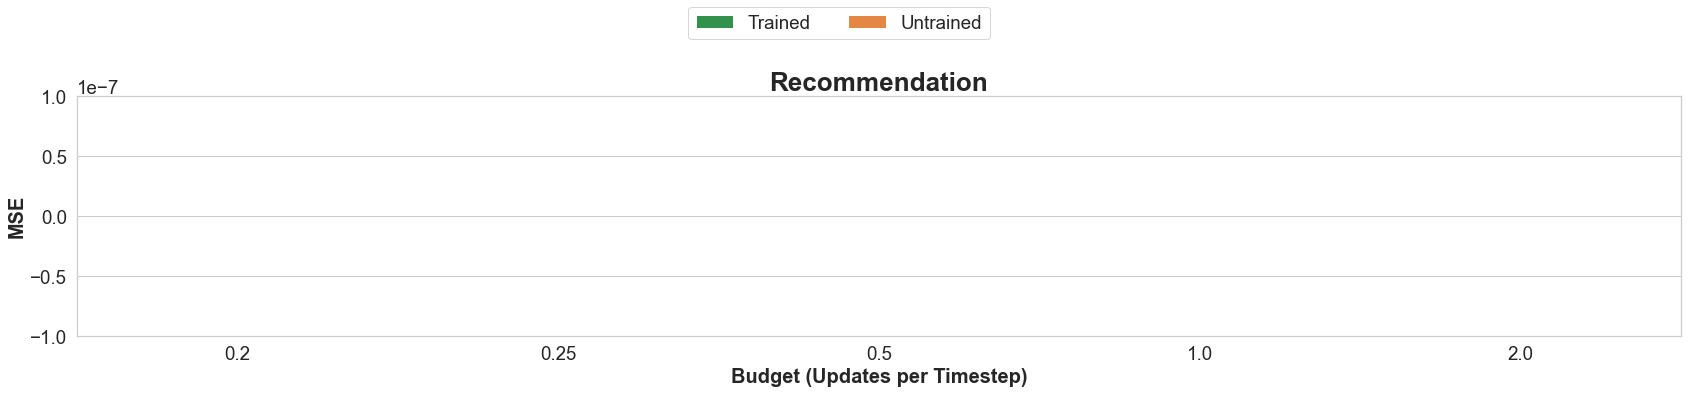

In [113]:
fig